In [2]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import kagglehub
import geopy.distance

In [3]:
path = kagglehub.dataset_download("usdot/flight-delays")

In [4]:
airlines = pd.read_csv(path + "//airlines.csv")
airports = pd.read_csv(path + "//airports.csv")
flights = pd.read_csv(path + "//flights.csv")

Data preprocessing 

In [5]:
airlines = { airlines.iloc[i][0] : airlines.iloc[i][1] for i in range(len(airlines))}
airports.index=airports["IATA_CODE"] #Make index by IATA_CODE
airports=airports.drop(columns=["IATA_CODE"])
airports=airports.dropna()
flights = flights[flights["ORIGIN_AIRPORT"].apply(lambda x : x in airports.index)]
flights[flights["DEPARTURE_DELAY"] < 0] = 0 #Negative delay is not delay at all
flights = flights.dropna(subset=["DEPARTURE_DELAY"]) #Delete nans in dep delay

In [6]:
flights.columns, airports.columns

(Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
        'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
        'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
        'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
        'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
        'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
        'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
       dtype='object'),
 Index(['AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'], dtype='object'))

Deleting incorrect airports names

In [8]:
flights = flights[(flights["ORIGIN_AIRPORT"].apply(str).apply(len) == 3) & (flights["DESTINATION_AIRPORT"].apply(str).apply(len) == 3)] #Filter incorrect names

# Hint 1 (Airports that have to be expanded)

In [9]:
delay_by_airport = flights.groupby(["ORIGIN_AIRPORT"])["DEPARTURE_DELAY"].median()
delay_by_airport_last_10per = delay_by_airport.loc[delay_by_airport.sort_values()[-int(delay_by_airport.shape[0]*0.1):].index]
delay_by_airport_first_90per = delay_by_airport.loc[delay_by_airport.sort_values()[0:int(delay_by_airport.shape[0]*0.9):].index]

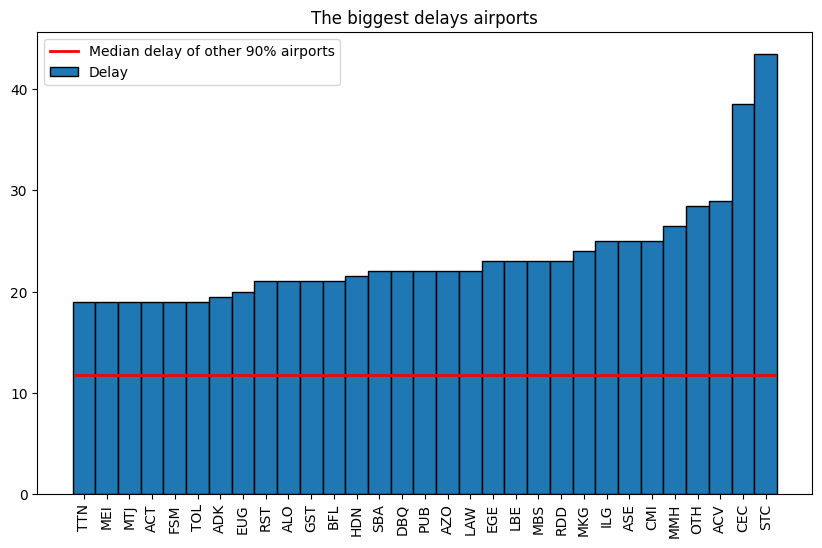

In [10]:
plt.figure(figsize=(10,6))
plt.bar(delay_by_airport_last_10per.index, delay_by_airport_last_10per, label="Delay", edgecolor="black", width=1)
plt.axhline(delay_by_airport_first_90per.mean(), 0.05,0.95, color="red", lw=2, label="Median delay of other 90% airports")
plt.xticks(rotation=90)
plt.title("The biggest delays airports")
plt.legend()
plt.show()

Here we see a situation, when airportes on the picture above can't permanentely manage with the passenger flow, their mean delay is much bigger than mean delay of 90% other airportes of the country. We need to expand these airports (hire more stuff or make more lines)

# Hint 2 (Redirect the flow of passengers to other airports)

In [34]:
from sklearn.metrics.pairwise import euclidean_distances
import folium

In [35]:
mapa = folium.Map(location=[40, -90], zoom_start=5)

In [36]:
nearest_neib = euclidean_distances(airports.loc[delay_by_airport_last_10per.index][["LATITUDE", "LONGITUDE"]], airports.loc[delay_by_airport_first_90per.index][["LATITUDE","LONGITUDE"]]).argmin(axis=1)

for i in range(delay_by_airport_last_10per.shape[0]):
    folium.Marker(location = [airports.loc[delay_by_airport_last_10per.index]["LATITUDE"].values[i], 
                              airports.loc[delay_by_airport_last_10per.index]["LONGITUDE"].values[i]],
                 icon = folium.Icon(color = "red", icon = 'plane', prefix ='fa')
                 ).add_to(mapa)

for i in range(delay_by_airport_first_90per.iloc[nearest_neib].shape[0]):
    folium.Marker(location = [airports.loc[delay_by_airport_first_90per.index].iloc[nearest_neib]["LATITUDE"].values[i], 
                              airports.loc[delay_by_airport_first_90per.index].iloc[nearest_neib]["LONGITUDE"].values[i]],
                 icon = folium.Icon(color = "blue", icon = 'plane', prefix ='fa')
                 ).add_to(mapa)

In [37]:
mapa

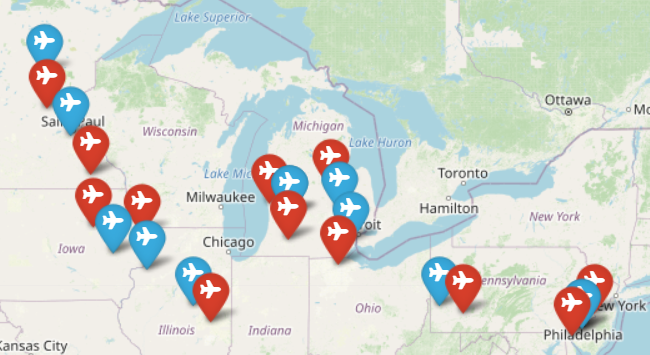                    
How it looks

Here I suggest to redirect the flow of passengeares into nearest airoports, especially the flow in the zone of the black triangle

In [13]:
map_of_redirecting = {delay_by_airport_last_10per.index[i] : airports.loc[delay_by_airport_first_90per.index].iloc[nearest_neib].index[i] 
                                                                                    for i in range(delay_by_airport_last_10per.shape[0])}
for key in map_of_redirecting:
    dist = geopy.distance.geodesic(airports.loc[key][["LATITUDE", "LONGITUDE"]].values, 
                airports.loc[map_of_redirecting[key]][["LATITUDE", "LONGITUDE"]].values).km
    print(f"""From {key} to {map_of_redirecting[key]}, distance is {dist:.2f} km""" + f" {"Good suggestion" if dist < 75 else "Bad suggestion"} ")

From TTN to PHL, distance is 57.88 km Good suggestion 
From MEI to PIB, distance is 110.87 km Bad suggestion 
From MTJ to GJT, distance is 87.52 km Bad suggestion 
From ACT to GRK, distance is 83.07 km Bad suggestion 
From FSM to XNA, distance is 105.03 km Bad suggestion 
From TOL to DTW, distance is 79.21 km Bad suggestion 
From ADK to OME, distance is 1548.41 km Bad suggestion 
From EUG to PDX, distance is 170.09 km Bad suggestion 
From RST to MSP, distance is 122.23 km Bad suggestion 
From ALO to CID, distance is 93.92 km Bad suggestion 
From GST to JNU, distance is 66.61 km Good suggestion 
From BFL to BUR, distance is 150.97 km Bad suggestion 
From HDN to LAR, distance is 159.41 km Bad suggestion 
From SBA to SMX, distance is 77.16 km Bad suggestion 
From DBQ to MLI, distance is 107.32 km Bad suggestion 
From PUB to COS, distance is 60.04 km Good suggestion 
From AZO to GRR, distance is 71.79 km Good suggestion 
From LAW to SPS, distance is 64.59 km Good suggestion 
From EGE to GU

# Hint 3 (Try to redirect the flow at some days of the week to other airports or other days)

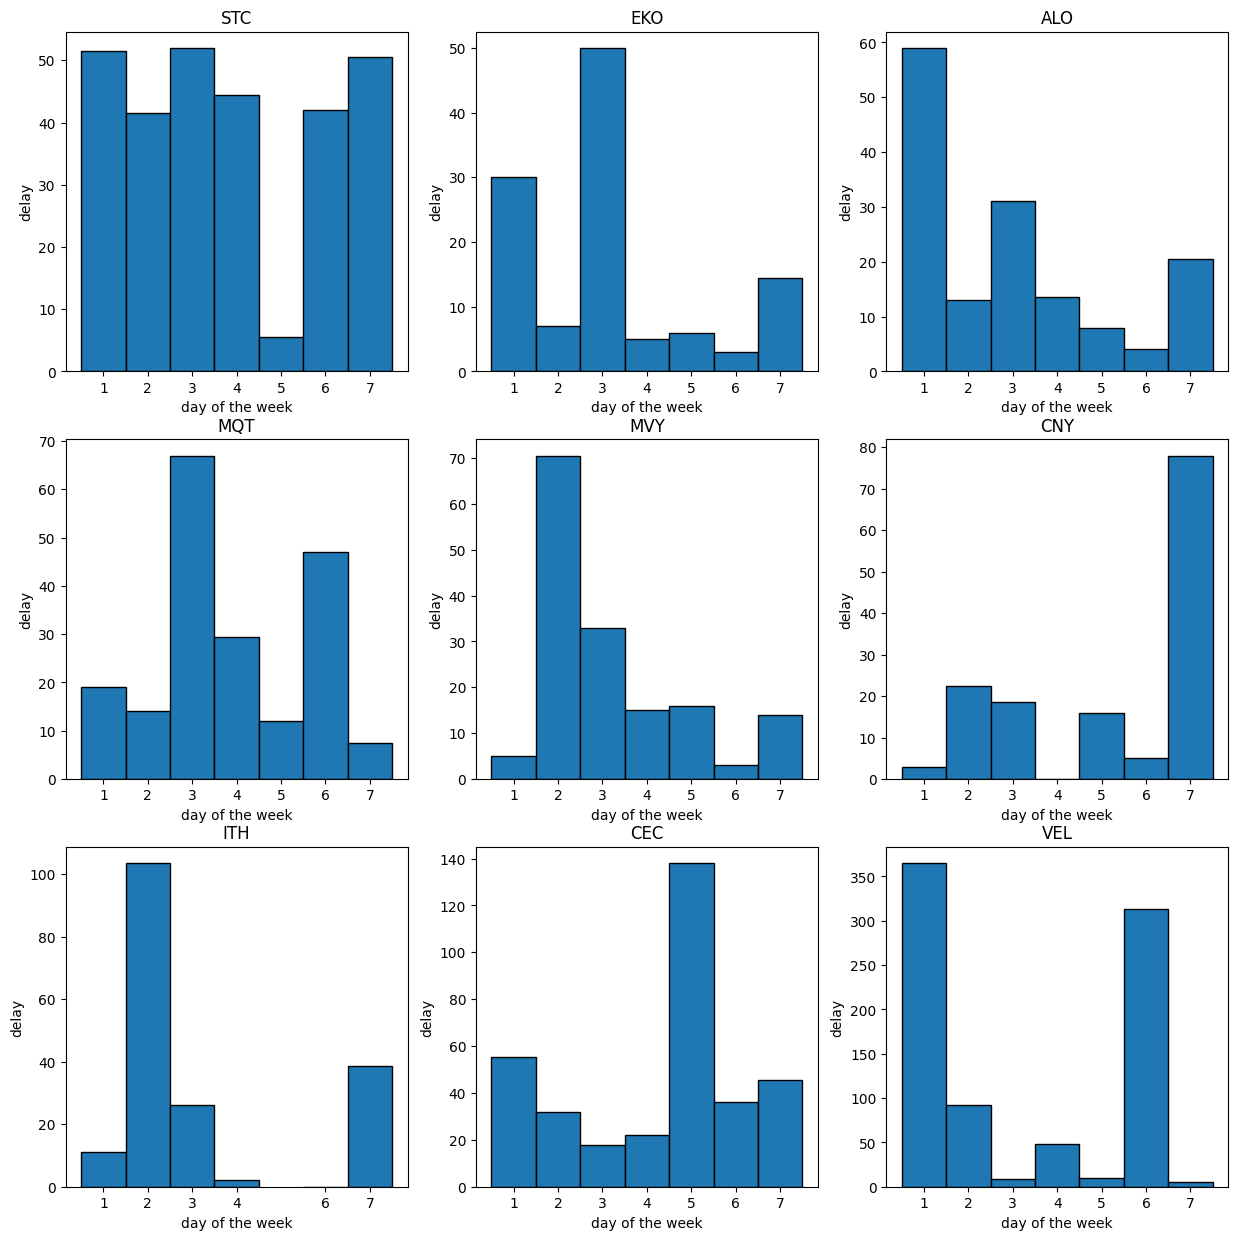

In [38]:
#Lets show airports delay_by_week_day bar, which delay difference is the biggest
delay_by_week_day = flights.groupby(["ORIGIN_AIRPORT", "DAY_OF_WEEK"])["DEPARTURE_DELAY"].median()
ind = delay_by_week_day.groupby(["ORIGIN_AIRPORT"]).agg(lambda x: max(x) - min(x)).sort_values()[-9:].index
days = flights.groupby(["ORIGIN_AIRPORT"])
days = days["DAY_OF_WEEK"].unique().apply(lambda x: np.sort(x))

fig, axes = plt.subplots(3,3, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    ax.bar(days.loc[ind[i]], delay_by_week_day.loc[ind[i]], width=1, edgecolor="black")
    ax.set_xticks(days.loc[ind[i]])
    ax.set_title(ind[i])
    ax.set_ylabel("delay")
    ax.set_xlabel("day of the week")

As we see here, we have another trouble, when airports have departure delay caused by ununiform density of the passengear flow.
We should redirect the flow on this days or make it more beneficial for people to travel at different days

# Hint 4 (Understand why some companies have biger delay issues compared to others)

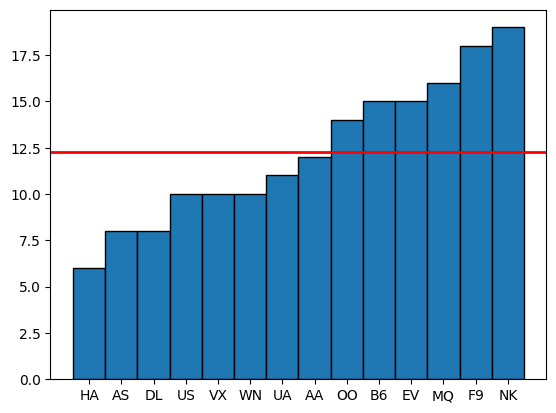

In [84]:
delay_by_line = flights.groupby(["AIRLINE"])["DEPARTURE_DELAY"].median().sort_values()
plt.bar(delay_by_line.index, delay_by_line, width=1, edgecolor="black")
plt.axhline(delay_by_line.mean(),0,1, color="red",lw=2)
plt.show()

In [13]:
" | ".join([airlines["B6"], airlines["OO"], airlines["MQ"], airlines["EV"], airlines["NK"], airlines["F9"]])

'JetBlue Airways | Skywest Airlines Inc. | American Eagle Airlines Inc. | Atlantic Southeast Airlines | Spirit Air Lines | Frontier Airlines Inc.'

We should understand why companies JetBlue Airways | Skywest Airlines Inc. | American Eagle Airlines Inc. | Atlantic Southeast Airlines | Spirit Air Lines | Frontier Airlines Inc. have permanent big delay issues

# Hint 5 (Reorganize flights departure time during the day)

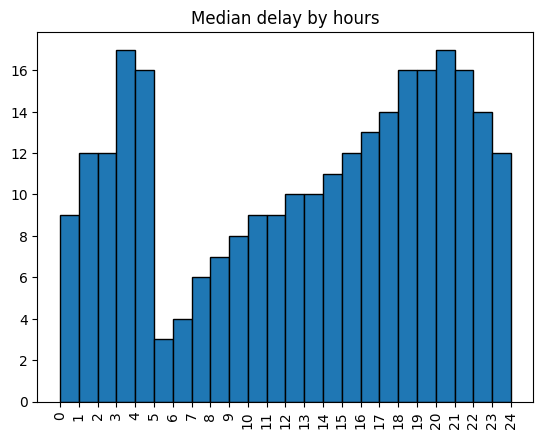

In [ ]:
flights["Aggregated time"] = flights["SCHEDULED_DEPARTURE"].apply(lambda x: x//100)
delay_by_hours = flights.groupby(["Aggregated time"])["DEPARTURE_DELAY"].median()
plt.bar(range(0,24), delay_by_hours, edgecolor="black", width=1, align="edge")
plt.xticks(range(0,25), rotation=90)
plt.title("Median delay by hours")
plt.show()

Here we see, that we can decreas median delay twice by reorganizing flights departure time within a day

# Hint 6 (Understand why some companies have biger cancelation issues compared to others)

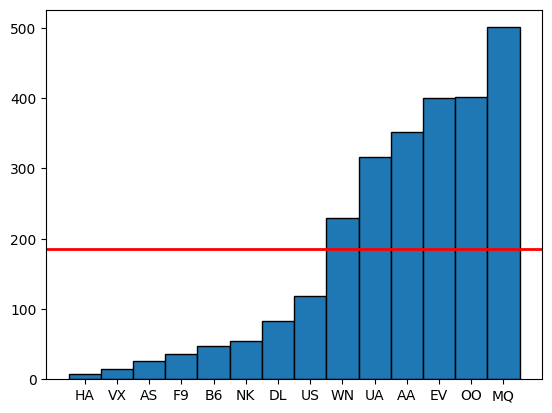

In [54]:
can = flights.groupby(["AIRLINE"])["CANCELLED"].sum().sort_values()
plt.bar(can.index, can, width=1, edgecolor="black")
plt.axhline(can.mean(),0,1, color="red",lw=2)
plt.show()

In [55]:
" | ".join([airlines["MQ"], airlines["OO"], airlines["EV"], airlines["UA"], airlines["AA"]])

'American Eagle Airlines Inc. | Skywest Airlines Inc. | Atlantic Southeast Airlines | United Air Lines Inc. | American Airlines Inc.'

We should understand why companies JetBlue Airways | Skywest Airlines Inc. | American Eagle Airlines Inc. | Atlantic Southeast Airlines | Spirit Air Lines | Frontier Airlines Inc. have permanent big cancellation issues